In [1]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import func_pytorch as functions
from opt_pytorch import FR_algorithm

import torch
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm
import random

goal='sync'
bifurcation='high'
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir)

# 10 nodes
n_nodes = 10
A = parameters['A'][:n_nodes,:n_nodes]
#A = np.zeros((5,5))
parameters['A'] = A
parameters['N'] = n_nodes


#Set dimensions
T= 30 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

switchfromto='none'
I_p=I_p_in

#choose initial condition for control
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

def set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise):

    #unpack parameters
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']

    #set random initials on circle with set amplitudes
    if bifurcation=='low':
        ini_y=torch.rand(N)/2+0.1
        ini_z=torch.rand(N)/5+.5
    elif bifurcation=='high':
        ini_y=torch.rand(N)
        ini_z=torch.rand(N)*0.3+1.0
    
    ini_transient=torch.stack((ini_y, ini_z)).transpose(0, 1)
    ini_transient=ini_transient.reshape(2,N)
    #print(ini_transient)

    return ini_transient

node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
#ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)
target_output=torch.ones((parameters['N'],parameters['N']))

args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.nn import Sequential, Linear, ReLU
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer

In [3]:
def data_nocontrol(batch_size, sim_length,L=None,**args):
    args['tsteps'] = sim_length
    N = args['N']
    dt = args['dt']
    args['T'] = int(sim_length*dt)
    # note that time steps = T/dt, dt=0.1
    while True:
        data = torch.zeros((batch_size, sim_length, 2, N))
        nocontrol = torch.zeros((sim_length, N))

        for b in range(batch_size):
            init = functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,sim_length,d,dt,parameters,realizations,noise)# (2,N)
            args['node_ic'] = init
            data[b, :, :, :] = functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args) # gives time seris of legth sim_length
        if L == None:
            # To return all the data at once
            yield(data)
        else:
            # To return the data in chunks of length L
            num_chunks = sim_length // L
            for i in range(sim_length-L+1):
                yield(data[:, i : i+L, :, :])

In [4]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr, u, batch):

        return src[:, 0] * edge_attr

        
class NodeModel(torch.nn.Module):
    def __init__(self, hidden_sizes):
        super().__init__()
        
        num_node_features = 2
        in_channels = 2+1 
        hiddens = 2*in_channels

        layers = []
        input_size = in_channels
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, num_node_features))
        
        self.node_mlp = nn.Sequential(*layers)
        
    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0),
                      reduce='sum')
        out = torch.cat([x, out.unsqueeze(1)], dim=1)
        return self.node_mlp(out)

## normalisation

In [5]:
#find mean and standard deviation
generator = data_nocontrol(1, 1000,L=None,**args)
data = []
for i in range(100):
    data.append(next(generator))

In [6]:
tensor_list = [torch.squeeze(t, dim=0) for t in data]
data4norm = torch.cat(tensor_list, dim=0)

In [7]:
data4norm.shape

torch.Size([100000, 2, 10])

In [8]:
mean = torch.mean(data4norm, dim=0)  
std = torch.std(data4norm, dim=0)   

In [9]:
mean.shape

torch.Size([2, 10])

In [11]:
adj = torch.ones(n_nodes,n_nodes)
torch.diagonal(adj, 0).zero_()
edge_index = adj.nonzero().t().contiguous()
edge_attr = A[edge_index[0], edge_index[1]]

In [25]:
edge_attr

tensor([0.0315, 0.0888, 0.0220, 0.1445, 0.0094, 0.2434, 0.0050, 0.0493, 0.0010,
        0.0315, 0.0088, 0.0921, 0.0031, 0.1222, 0.0031, 0.1655, 0.0009, 0.0211,
        0.0888, 0.0088, 0.0462, 0.3593, 0.0270, 0.0568, 0.0153, 0.0545, 0.0125,
        0.0220, 0.0921, 0.0462, 0.0338, 0.3122, 0.0152, 0.0653, 0.0154, 0.0491,
        0.1445, 0.0031, 0.3593, 0.0338, 0.0249, 0.1154, 0.0122, 0.2321, 0.0119,
        0.0094, 0.1222, 0.0270, 0.3122, 0.0249, 0.0080, 0.1501, 0.0127, 0.2238,
        0.2434, 0.0031, 0.0568, 0.0152, 0.1154, 0.0080, 0.0049, 0.3173, 0.0030,
        0.0050, 0.1655, 0.0153, 0.0653, 0.0122, 0.1501, 0.0049, 0.0057, 0.2923,
        0.0493, 0.0009, 0.0545, 0.0154, 0.2321, 0.0127, 0.3173, 0.0057, 0.0087,
        0.0010, 0.0211, 0.0125, 0.0491, 0.0119, 0.2238, 0.0030, 0.2923, 0.0087])

In [68]:
def data_normalized(batch_size, sim_length,L=None,**args):
    args['tsteps'] = sim_length
    N = args['N']
    dt = args['dt']
    args['T'] = int(sim_length*dt)
    # note that time steps = T/dt, dt=0.1
    while True:
        data = torch.zeros((batch_size, sim_length, 2, N))
        nocontrol = torch.zeros((sim_length, N))

        for b in range(batch_size):
            init = functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,sim_length,d,dt,parameters,realizations,noise)# (2,N)
            args['node_ic'] = init
            data[b, :, :, :] = functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args) # gives time seris of legth sim_length
        #normalize
        data = (data - mean.unsqueeze(0).unsqueeze(0)) / std.unsqueeze(0).unsqueeze(0)
        if L == None:
            # To return all the data at once
            yield(data)
        else:
            # To return the data in chunks of length L
            num_chunks = sim_length // L
            for i in range(sim_length-L+1):
                yield(data[:, i : i+L, :, :])

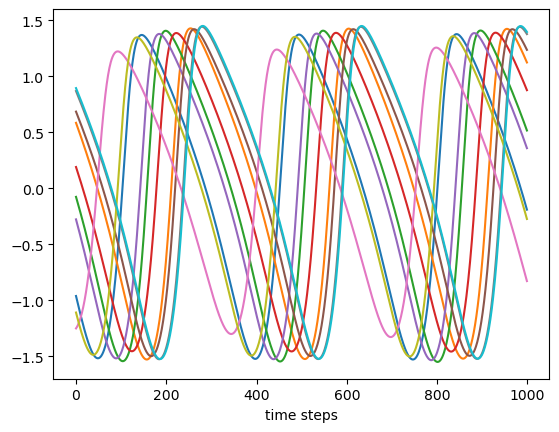

In [63]:
norm_generator = data_normalized(1, 1000,L=None,**args)
b=next(norm_generator)
b=b.squeeze(0)
plt.plot(b[:,0,:])
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
#plt.title('sample normalised data')
plt.show()

In [29]:
# Define your grid
node_hidden_layer_combinations = [[16,32,16]]
learning_rates = [0.001]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_ahead = 10

max_epochs = 100000

train_generator = data_normalized(1, 400,L=10,**args)  # Assuming you've defined this already
valid_generator = data_normalized(1, 400,L=10,**args)  # A separate generator for validation

# Start the grid search
results = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    # Create your models with the current hyperparameters
    edge_model = EdgeModel().to(device)
    node_model = NodeModel(node_sizes).to(device)
    model = MetaLayer(edge_model, node_model).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses = []
    valid_losses = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model.train()
        optimizer.zero_grad()
        loss = 0
        current_state = states[0, :]
        for k in range(look_ahead-1):
            prediction = model(current_state.T, edge_index, edge_attr)[0].T
            loss = loss + loss_fn(prediction, states[k + 1, :])
            current_state = prediction
        
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            current_state = states[0, :]
            for k in range(look_ahead-1):
                prediction = model(current_state.T, edge_index, edge_attr)[0].T
                valid_loss += loss_fn(prediction, states[k + 1, :])
                current_state = prediction
                
            valid_losses.append(valid_loss.item())

        epoch += 1  
        if (epoch + 1) % 10000 == 0: 
            print(f"Epoch {epoch + 1},Current Loss: {loss_value}")

Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.001
Epoch 10000,Current Loss: 0.0034900535829365253
Epoch 20000,Current Loss: 0.007454350590705872
Epoch 30000,Current Loss: 0.006700369529426098
Epoch 40000,Current Loss: 0.0030297613702714443
Epoch 50000,Current Loss: 0.0013199395034462214
Epoch 60000,Current Loss: 0.001136398990638554
Epoch 70000,Current Loss: 0.05447857454419136
Epoch 80000,Current Loss: 0.0003676614724099636
Epoch 90000,Current Loss: 0.0010933814337477088
Epoch 100000,Current Loss: 0.0006407945184037089


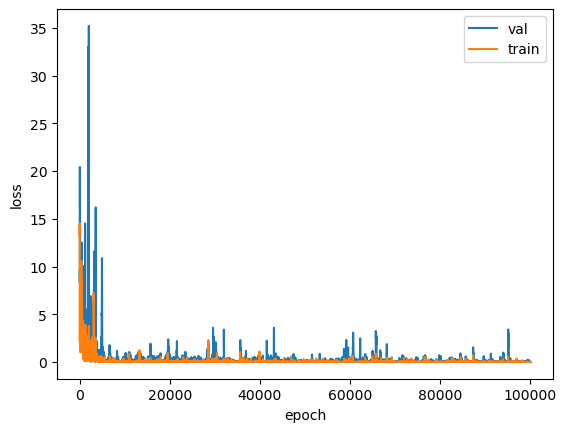

In [70]:
plt.plot(valid_losses,label='val')
plt.plot(train_losses,label='train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [34]:
model.eval()
sim_length=400
t = 0
test_generator = data_normalized(1, 1000,L=10,**args)
states= next(test_generator)
states= states.to(device)
if states.shape[0] == 1:
    states = states.squeeze(0)
state = states[0,:,:]
pred_list = [state]
true_list = [state]

while t<sim_length:
    x = pred_list[t]
    pred = model(x.T,edge_index,edge_attr)[0].T
    pred_list.append(pred)
    
    states= next(test_generator) 
    states= states.to(device)
    if states.shape[0] == 1:
        states = states.squeeze(0)
    state = states[0,:,:]
    true_list.append(state)
    t = t+1

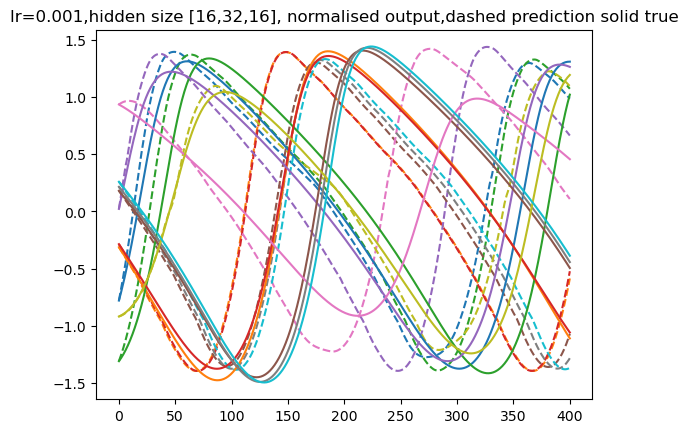

In [37]:
pred_traj = torch.stack(pred_list, dim=0)
true_traj = torch.stack(true_list, dim=0)
plt.plot(pred_traj[:500,0,:].detach(),'--',label='prediction')
plt.plot(true_traj[:500,0,:],label='true')
plt.title('lr=0.001,hidden size [16,32,16], normalised output,dashed prediction solid true')
plt.show()

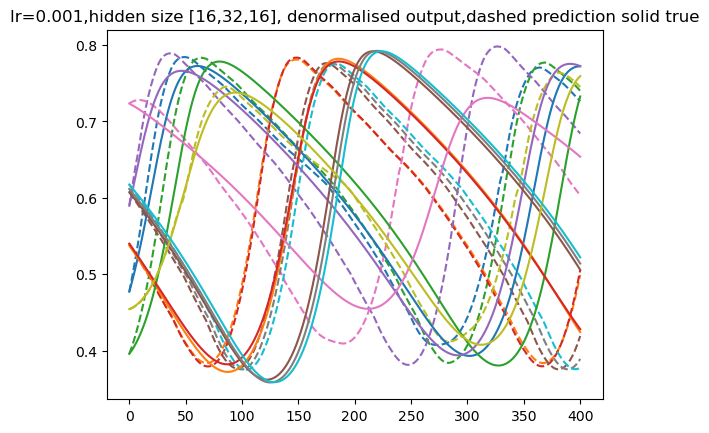

In [38]:
denormalized_pred = (pred_traj.detach() * std.unsqueeze(0)) + mean.unsqueeze(0)
denormalized_true = (true_traj.detach() * std.unsqueeze(0)) + mean.unsqueeze(0)
plt.plot(denormalized_pred[:,0,:],'--',label='prediction')
plt.plot(denormalized_true[:,0,:],label='true')
plt.title('lr=0.001,hidden size [16,32,16], denormalised output,dashed prediction solid true')
plt.show()

In [40]:
model_path = os.path.join('grid_search', f"model_normnode_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}_la_{look_ahead}.pth")
torch.save(model.state_dict(), model_path)

In [44]:
edge_attr

tensor([0.0315, 0.0888, 0.0220, 0.1445, 0.0094, 0.2434, 0.0050, 0.0493, 0.0010,
        0.0315, 0.0088, 0.0921, 0.0031, 0.1222, 0.0031, 0.1655, 0.0009, 0.0211,
        0.0888, 0.0088, 0.0462, 0.3593, 0.0270, 0.0568, 0.0153, 0.0545, 0.0125,
        0.0220, 0.0921, 0.0462, 0.0338, 0.3122, 0.0152, 0.0653, 0.0154, 0.0491,
        0.1445, 0.0031, 0.3593, 0.0338, 0.0249, 0.1154, 0.0122, 0.2321, 0.0119,
        0.0094, 0.1222, 0.0270, 0.3122, 0.0249, 0.0080, 0.1501, 0.0127, 0.2238,
        0.2434, 0.0031, 0.0568, 0.0152, 0.1154, 0.0080, 0.0049, 0.3173, 0.0030,
        0.0050, 0.1655, 0.0153, 0.0653, 0.0122, 0.1501, 0.0049, 0.0057, 0.2923,
        0.0493, 0.0009, 0.0545, 0.0154, 0.2321, 0.0127, 0.3173, 0.0057, 0.0087,
        0.0010, 0.0211, 0.0125, 0.0491, 0.0119, 0.2238, 0.0030, 0.2923, 0.0087])

In [43]:
edge_mean = edge_attr.mean()
edge_std = edge_attr.std()
# Normalize
normalized_edge_attr = (edge_attr - edge_mean) / edge_std

In [45]:
normalized_edge_attr

tensor([-0.4631,  0.1113, -0.5584,  0.6690, -0.6848,  1.6604, -0.7288, -0.2847,
        -0.7686, -0.4631, -0.6909,  0.1442, -0.7479,  0.4457, -0.7475,  0.8795,
        -0.7696, -0.5676,  0.1113, -0.6909, -0.3158,  2.8223, -0.5080, -0.2099,
        -0.6256, -0.2327, -0.6533, -0.5584,  0.1442, -0.3158, -0.4401,  2.3501,
        -0.6268, -0.1244, -0.6243, -0.2870,  0.6690, -0.7479,  2.8223, -0.4401,
        -0.5292,  0.3777, -0.6565,  1.5468, -0.6596, -0.6848,  0.4457, -0.5080,
         2.3501, -0.5292, -0.6989,  0.7250, -0.6520,  1.4641,  1.6604, -0.7475,
        -0.2099, -0.6268,  0.3777, -0.6989, -0.7296,  2.4013, -0.7485, -0.7288,
         0.8795, -0.6256, -0.1244, -0.6565,  0.7250, -0.7296, -0.7217,  2.1501,
        -0.2847, -0.7696, -0.2327, -0.6243,  1.5468, -0.6520,  2.4013, -0.7217,
        -0.6918, -0.7686, -0.5676, -0.6533, -0.2870, -0.6596,  1.4641, -0.7485,
         2.1501, -0.6918])

In [46]:
# Define your grid
node_hidden_layer_combinations = [[16,32,16]]
learning_rates = [0.001]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_ahead = 10

max_epochs = 100000

train_generator = data_normalized(1, 400,L=10,**args)  # Assuming you've defined this already
valid_generator = data_normalized(1, 400,L=10,**args)  # A separate generator for validation

# Start the grid search
results = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    # Create your models with the current hyperparameters
    edge_model = EdgeModel().to(device)
    node_model = NodeModel(node_sizes).to(device)
    model = MetaLayer(edge_model, node_model).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses = []
    valid_losses = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model.train()
        optimizer.zero_grad()
        loss = 0
        current_state = states[0, :]
        for k in range(look_ahead-1):
            prediction = model(current_state.T, edge_index, normalized_edge_attr)[0].T
            loss = loss + loss_fn(prediction, states[k + 1, :])
            current_state = prediction
        
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            current_state = states[0, :]
            for k in range(look_ahead-1):
                prediction = model(current_state.T, edge_index, normalized_edge_attr)[0].T
                valid_loss += loss_fn(prediction, states[k + 1, :])
                current_state = prediction
                
            valid_losses.append(valid_loss.item())

        epoch += 1  
        if (epoch + 1) % 10000 == 0: 
            print(f"Epoch {epoch + 1},Current Loss: {loss_value}")

Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.001
Epoch 10000,Current Loss: 3.603982448577881
Epoch 20000,Current Loss: 0.09581953287124634
Epoch 30000,Current Loss: 0.023020265623927116
Epoch 40000,Current Loss: 0.03627781942486763
Epoch 50000,Current Loss: 0.004665662068873644
Epoch 60000,Current Loss: 0.003988169599324465
Epoch 70000,Current Loss: 0.0576956644654274
Epoch 80000,Current Loss: 0.029119007289409637
Epoch 90000,Current Loss: 0.008182997815310955
Epoch 100000,Current Loss: 0.00946863368153572


In [47]:
model.eval()
sim_length=400
t = 0
test_generator = data_normalized(1, 1000,L=10,**args)
states= next(test_generator)
states= states.to(device)
if states.shape[0] == 1:
    states = states.squeeze(0)
state = states[0,:,:]
pred_list = [state]
true_list = [state]

while t<sim_length:
    x = pred_list[t]
    pred = model(x.T,edge_index,normalized_edge_attr)[0].T
    pred_list.append(pred)
    
    states= next(test_generator) 
    states= states.to(device)
    if states.shape[0] == 1:
        states = states.squeeze(0)
    state = states[0,:,:]
    true_list.append(state)
    t = t+1

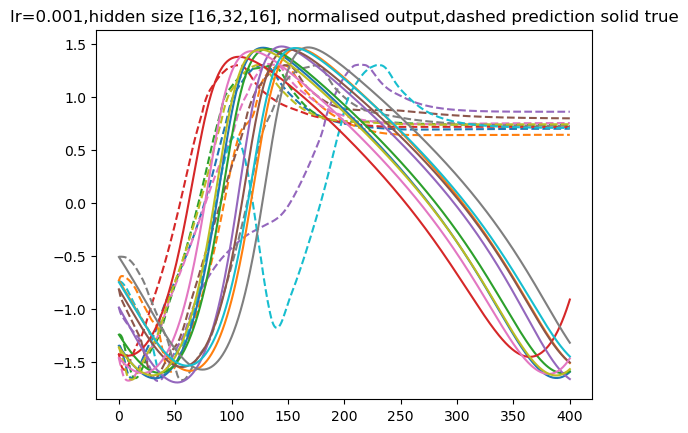

In [48]:
pred_traj = torch.stack(pred_list, dim=0)
true_traj = torch.stack(true_list, dim=0)
plt.plot(pred_traj[:500,0,:].detach(),'--',label='prediction')
plt.plot(true_traj[:500,0,:],label='true')
plt.title('lr=0.001,hidden size [16,32,16], normalised output,dashed prediction solid true')
plt.show()

In [49]:
model_path = os.path.join('grid_search', f"model_zeromeanedge_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}_la_{look_ahead}.pth")
torch.save(model.state_dict(), model_path)

In [50]:
edge_min = edge_attr.min()
edge_max = edge_attr.max()
# Normalize
minmax_edge_attr = (edge_attr - edge_min) / (edge_max - edge_min)

In [52]:
edge_attr

tensor([0.0315, 0.0888, 0.0220, 0.1445, 0.0094, 0.2434, 0.0050, 0.0493, 0.0010,
        0.0315, 0.0088, 0.0921, 0.0031, 0.1222, 0.0031, 0.1655, 0.0009, 0.0211,
        0.0888, 0.0088, 0.0462, 0.3593, 0.0270, 0.0568, 0.0153, 0.0545, 0.0125,
        0.0220, 0.0921, 0.0462, 0.0338, 0.3122, 0.0152, 0.0653, 0.0154, 0.0491,
        0.1445, 0.0031, 0.3593, 0.0338, 0.0249, 0.1154, 0.0122, 0.2321, 0.0119,
        0.0094, 0.1222, 0.0270, 0.3122, 0.0249, 0.0080, 0.1501, 0.0127, 0.2238,
        0.2434, 0.0031, 0.0568, 0.0152, 0.1154, 0.0080, 0.0049, 0.3173, 0.0030,
        0.0050, 0.1655, 0.0153, 0.0653, 0.0122, 0.1501, 0.0049, 0.0057, 0.2923,
        0.0493, 0.0009, 0.0545, 0.0154, 0.2321, 0.0127, 0.3173, 0.0057, 0.0087,
        0.0010, 0.0211, 0.0125, 0.0491, 0.0119, 0.2238, 0.0030, 0.2923, 0.0087])

In [57]:
# Define your grid
node_hidden_layer_combinations = [[16,32,16]]
learning_rates = [0.001]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_ahead = 10

max_epochs = 100000

train_generator = data_normalized(1, 400,L=10,**args)  # Assuming you've defined this already
valid_generator = data_normalized(1, 400,L=10,**args)  # A separate generator for validation

# Start the grid search
results = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    # Create your models with the current hyperparameters
    edge_model = EdgeModel().to(device)
    node_model = NodeModel(node_sizes).to(device)
    model = MetaLayer(edge_model, node_model).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses = []
    valid_losses = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model.train()
        optimizer.zero_grad()
        loss = 0
        current_state = states[0, :]
        for k in range(look_ahead-1):
            prediction = model(current_state.T, edge_index, minmax_edge_attr)[0].T
            loss = loss + loss_fn(prediction, states[k + 1, :])
            current_state = prediction
        
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            current_state = states[0, :]
            for k in range(look_ahead-1):
                prediction = model(current_state.T, edge_index, minmax_edge_attr)[0].T
                valid_loss += loss_fn(prediction, states[k + 1, :])
                current_state = prediction
                
            valid_losses.append(valid_loss.item())

        epoch += 1  
        if (epoch + 1) % 10000 == 0: 
            print(f"Epoch {epoch + 1},Current Loss: {loss_value}")

Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.001
Epoch 10000,Current Loss: 0.0037136126775294542
Epoch 20000,Current Loss: 0.0043177008628845215
Epoch 30000,Current Loss: 0.005895712878555059
Epoch 40000,Current Loss: 0.0012083324836567044
Epoch 50000,Current Loss: 0.003882968332618475
Epoch 60000,Current Loss: 0.004041451960802078
Epoch 70000,Current Loss: 0.005413980223238468
Epoch 80000,Current Loss: 0.004335654899477959
Epoch 90000,Current Loss: 0.0014920704998075962
Epoch 100000,Current Loss: 0.0007413111161440611


In [61]:
current_state.shape

torch.Size([2, 10])

In [58]:
model.eval()
sim_length=400
t = 0
test_generator = data_normalized(1, 1000,L=10,**args)
states= next(test_generator)
states= states.to(device)
if states.shape[0] == 1:
    states = states.squeeze(0)
state = states[0,:,:]
pred_list = [state]
true_list = [state]

while t<sim_length:
    x = pred_list[t]
    pred = model(x.T,edge_index,minmax_edge_attr)[0].T
    pred_list.append(pred)
    
    states= next(test_generator) 
    states= states.to(device)
    if states.shape[0] == 1:
        states = states.squeeze(0)
    state = states[0,:,:]
    true_list.append(state)
    t = t+1

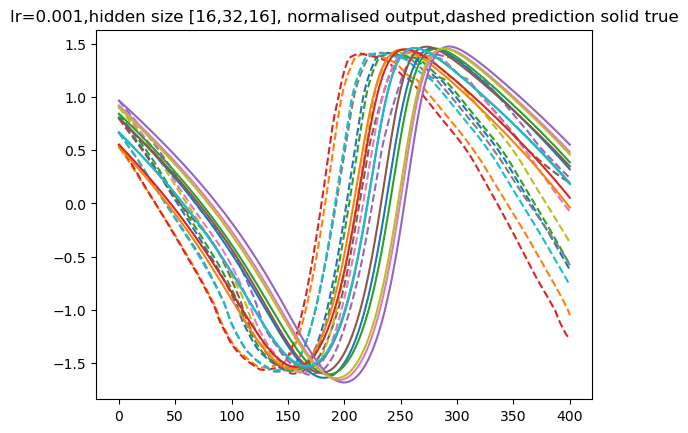

In [59]:
pred_traj = torch.stack(pred_list, dim=0)
true_traj = torch.stack(true_list, dim=0)
plt.plot(pred_traj[:500,0,:].detach(),'--',label='prediction')
plt.plot(true_traj[:500,0,:],label='true')
plt.title('lr=0.001,hidden size [16,32,16], normalised output,dashed prediction solid true')
plt.show()

In [60]:
model_path = os.path.join('grid_search', f"model_minmaxedge_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}_la_{look_ahead}.pth")
torch.save(model.state_dict(), model_path)

## plots for report

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = MetaLayer(EdgeModel(), NodeModel([16,32,16])).to(device)
model1.load_state_dict(torch.load('./grid_search/model_node_16_32_16_lr_0.001.pth'))

model2 = MetaLayer(EdgeModel(), NodeModel([16,32,16])).to(device)
model2.load_state_dict(torch.load('./grid_search/model_normnode_node_16_32_16_lr_0.001_la_10.pth'))

model3 = MetaLayer(EdgeModel(), NodeModel([16,32,16])).to(device)
model3.load_state_dict(torch.load('./grid_search/model_zeromeanedge_node_16_32_16_lr_0.001_la_10.pth'))

model4 = MetaLayer(EdgeModel(), NodeModel([16,32,16])).to(device)
model4.load_state_dict(torch.load('./grid_search/model_minmaxedge_node_16_32_16_lr_0.001_la_10.pth'))

<All keys matched successfully>

In [78]:
model1.eval()
model2.eval()
model3.eval()
model4.eval()
sim_length=1000
t = 0
test_generator = data_normalized(1, 1000,L=None,**args)
states= next(test_generator)
states= states.to(device)
if states.shape[0] == 1:
    states = states.squeeze(0)

In [87]:
state = states[0,:,:]
pred_list2 = [state]
pred_list3 = [state]
pred_list4 = [state]

for t in range(sim_length):
    x = pred_list2[t]
    pred = model2(x.T,edge_index,edge_attr)[0].T
    pred_list2.append(pred)

    x = pred_list3[t]
    pred = model3(x.T,edge_index,normalized_edge_attr)[0].T
    pred_list3.append(pred)
    
    x = pred_list4[t]
    pred = model4(x.T,edge_index,minmax_edge_attr)[0].T
    pred_list4.append(pred)

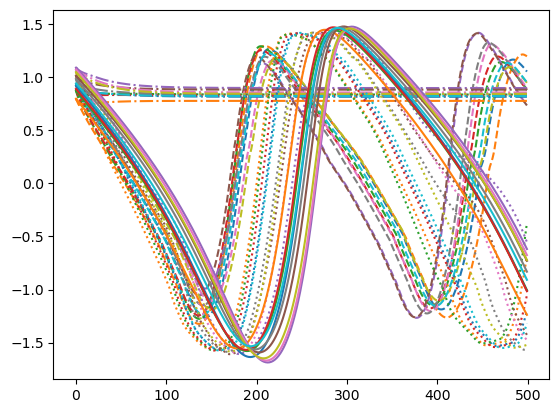

In [85]:
pred_traj2 = torch.stack(pred_list2, dim=0)
plt.plot(pred_traj2[:500,0,:].detach(),'--',label='prediction')
pred_traj3 = torch.stack(pred_list3, dim=0)
plt.plot(pred_traj3[:500,0,:].detach(),'-.',label='prediction')
pred_traj4 = torch.stack(pred_list4, dim=0)
plt.plot(pred_traj4[:500,0,:].detach(),':',label='prediction')
plt.plot(states[:500,0,:],label='true')
plt.plot
plt.show()

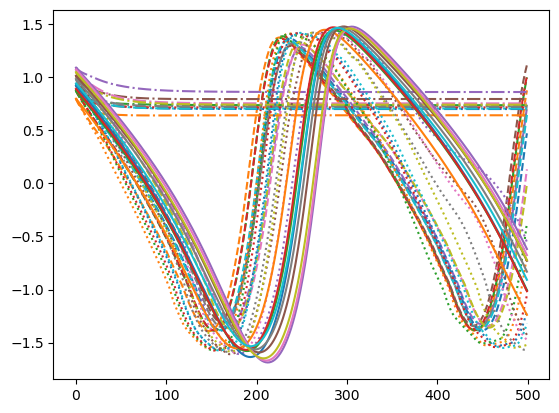

In [88]:
pred_traj2 = torch.stack(pred_list2, dim=0)
plt.plot(pred_traj2[:500,0,:].detach(),'--',label='prediction')
pred_traj3 = torch.stack(pred_list3, dim=0)
plt.plot(pred_traj3[:500,0,:].detach(),'-.',label='prediction')
pred_traj4 = torch.stack(pred_list4, dim=0)
plt.plot(pred_traj4[:500,0,:].detach(),':',label='prediction')
plt.plot(states[:500,0,:],label='true')
plt.plot
plt.show()

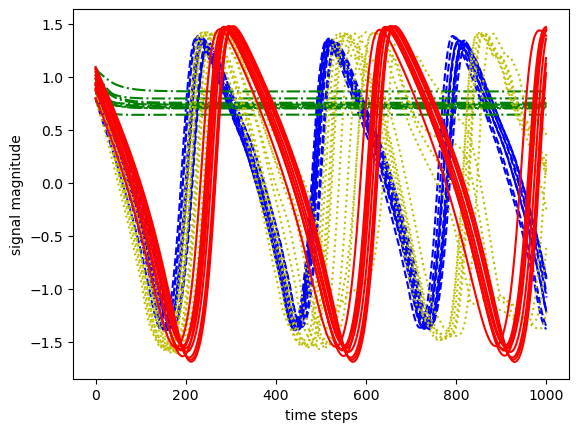

In [96]:
pred_traj2 = torch.stack(pred_list2, dim=0)
plt.plot(pred_traj2[:,0,:].detach(),'b--',label='prediction')
pred_traj3 = torch.stack(pred_list3, dim=0)
plt.plot(pred_traj3[:,0,:].detach(),'g-.',label='prediction')
pred_traj4 = torch.stack(pred_list4, dim=0)
plt.plot(pred_traj4[:,0,:].detach(),'y:',label='prediction')
plt.plot(states[:,0,:],'r',label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.show()

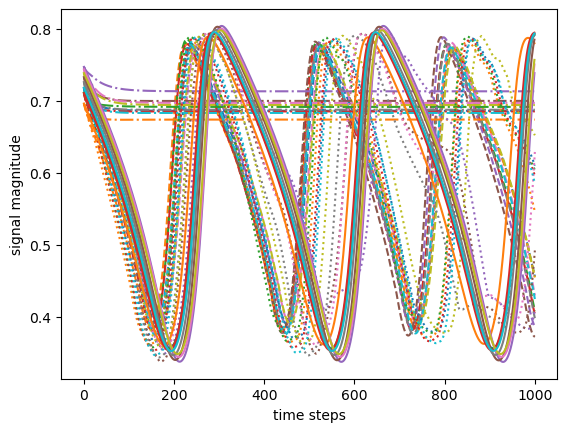

In [100]:
denormalized_pred2 = (pred_traj2.detach() * std.unsqueeze(0)) + mean.unsqueeze(0)
denormalized_pred3 = (pred_traj3.detach() * std.unsqueeze(0)) + mean.unsqueeze(0)
denormalized_pred4 = (pred_traj4.detach() * std.unsqueeze(0)) + mean.unsqueeze(0)
denormalized_states = (states * std.unsqueeze(0)) + mean.unsqueeze(0)
plt.plot(denormalized_pred2[:,0,:],'--',label='prediction')
plt.plot(denormalized_pred3[:,0,:],'-.',label='prediction')
plt.plot(denormalized_pred4[:,0,:],':',label='prediction')
plt.plot(denormalized_states[:,0,:],'',label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.show()

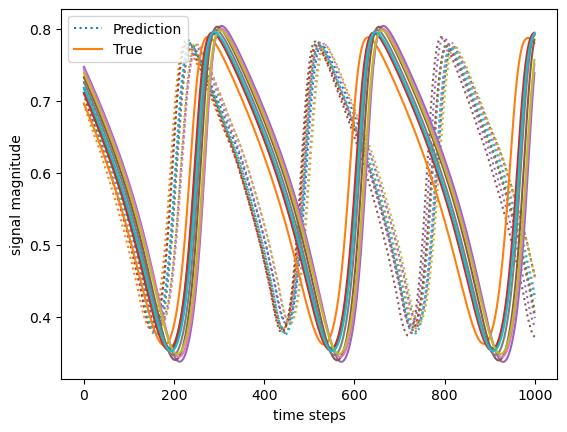

In [108]:
plt.plot(denormalized_pred2[:,0,:].detach(),':',label='prediction')
plt.plot(denormalized_states[:,0,:],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], linestyle=':', color='C0', label='Prediction'),
                   Line2D([0], [0], linestyle='-', color='C1', label='True')]
plt.legend(handles=legend_elements)
plt.show()

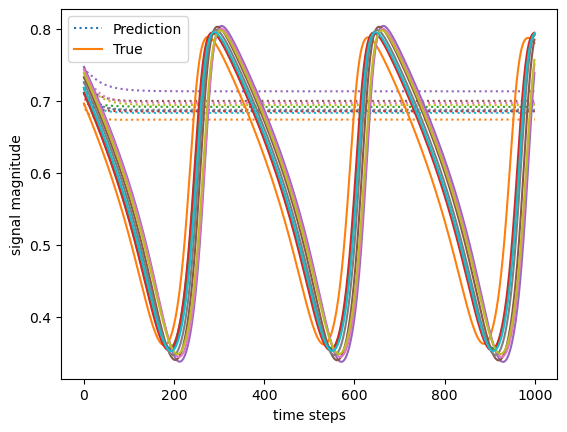

In [109]:
plt.plot(denormalized_pred3[:,0,:].detach(),':',label='prediction')
plt.plot(denormalized_states[:,0,:],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.legend(handles=legend_elements)
plt.show()

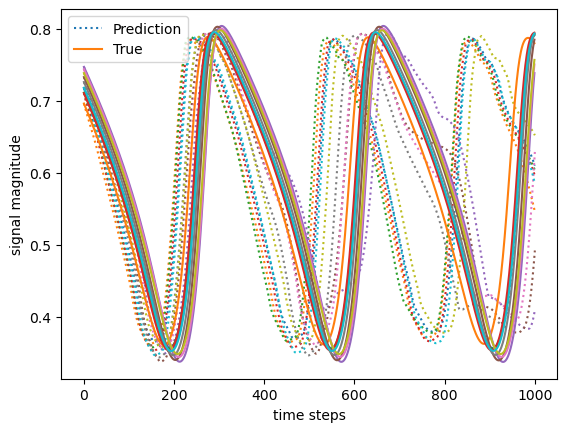

In [110]:
plt.plot(denormalized_pred4[:,0,:].detach(),':',label='prediction')
plt.plot(denormalized_states[:,0,:],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.legend(handles=legend_elements)
plt.show()

In [106]:
pred_list1 = [denormalized_states[0,:,:]]
for t in range(sim_length):
    x = pred_list1[t]
    pred = model1(x.T,edge_index,edge_attr)[0].T
    pred_list1.append(pred)

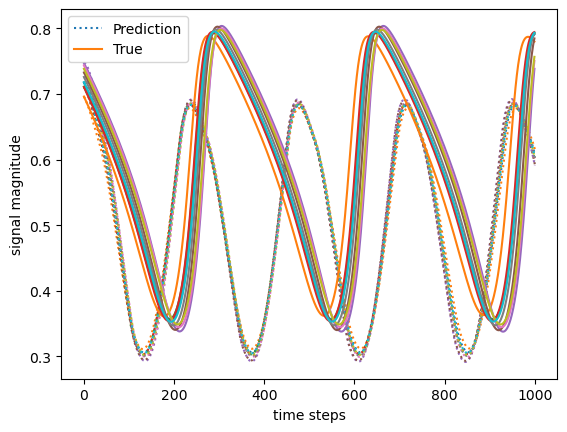

In [111]:
pred_traj1 = torch.stack(pred_list1, dim=0)
plt.plot(pred_traj1[:,0,:].detach(),':',label='prediction')
plt.plot(denormalized_states[:,0,:],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.legend(handles=legend_elements)
plt.show()

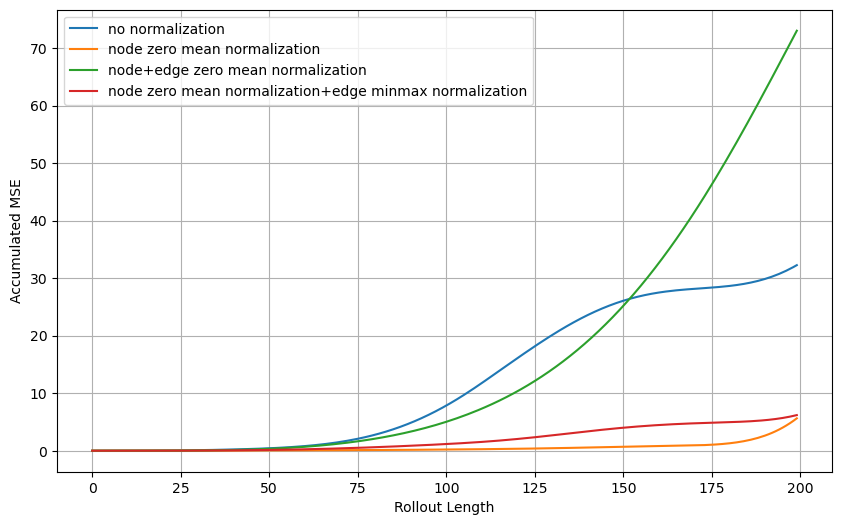

In [123]:
# Calculate MSE for each rollout length
mse_values = []
mse_values2 = []
mse_values3 = []
mse_values4 = []
mse_loss = nn.MSELoss(reduction='sum')
mse_rollout = 200
for i in range(mse_rollout):
    mse = mse_loss(denormalized_states[:i+1,:,:], pred_traj1[:i+1,:,:].detach())
    mse_values.append(mse)
    
for i in range(mse_rollout):
    mse = mse_loss(denormalized_states[:i+1,:,:], denormalized_pred2[:i+1,:,:].detach())
    mse_values2.append(mse)
    
for i in range(mse_rollout):
    mse = mse_loss(denormalized_states[:i+1,:,:], denormalized_pred3[:i+1,:,:].detach())
    mse_values3.append(mse)
    
for i in range(mse_rollout):
    mse = mse_loss(denormalized_states[:i+1,:,:], denormalized_pred4[:i+1,:,:].detach())
    mse_values4.append(mse)

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(mse_values,label='no normalization')
plt.plot(mse_values2,label='node zero mean normalization')
plt.plot(mse_values3,label='node+edge zero mean normalization')
plt.plot(mse_values4,label='node zero mean normalization+edge minmax normalization')
plt.xlabel('Rollout Length')
plt.ylabel('Accumulated MSE')
plt.legend()
plt.grid(True)
plt.show()

## baseline

In [124]:
class SimpleMLP(nn.Module):
    def __init__(self, hidden_sizes):
        super(SimpleMLP, self).__init__()
        
        input_size = 2
        output_size = 2
        
        layers = []
        current_input = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_input, hidden_size))
            layers.append(nn.ReLU())
            current_input = hidden_size

        layers.append(nn.Linear(current_input, output_size))
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [129]:
#best MLP is [16,32,16] with lr 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_node_sizes = [16,32,16]
model_mlp = SimpleMLP(best_node_sizes).to(device)
model_mlp.load_state_dict(torch.load('./mlp_grid_search/model_node_16_32_16_lr_0.001.pth'))

<All keys matched successfully>

In [126]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, hidden_sizes):
        super(GCN, self).__init__()
        
        self.layers = nn.ModuleList()

        input_size = 2
        
        # Create GCN layers based on hidden_sizes
        for hidden_size in hidden_sizes:
            self.layers.append(GCNConv(input_size, hidden_size))
            input_size = hidden_size
            
        self.layers.append(GCNConv(input_size, 2))

    def forward(self, x, edge_index, edge_attr):
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            
        x = self.layers[-1](x, edge_index, edge_attr)
        return x


In [130]:
#best GCN is [16,32,16] with lr 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_node_sizes = [16, 32, 64, 32, 16]
model_gcn = GCN(best_node_sizes).to(device)
model_gcn.load_state_dict(torch.load('./gcn_grid_search/model_node_16_32_64_32_16_lr_0.01.pth'))

<All keys matched successfully>

In [134]:
model_mlp.eval()
model_gcn.eval()
pred_list5 = [denormalized_states[0,:,:]]
pred_list6 = [denormalized_states[0,:,:]]
for t in range(sim_length):
    x = pred_list5[t]
    pred = model_mlp(x.T).T
    pred_list5.append(pred)
    
    x = pred_list6[t]
    pred = model_gcn(x.T,edge_index, edge_attr).T
    pred_list6.append(pred)

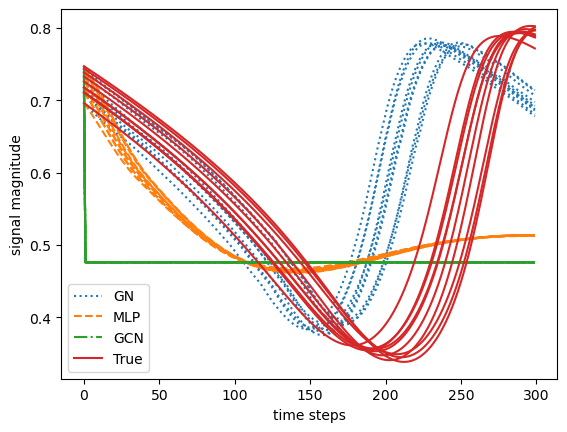

In [146]:
plt.plot(denormalized_pred2[:300,0,:].detach(),'C0:',label='prediction')
pred_traj5 = torch.stack(pred_list5, dim=0)
plt.plot(pred_traj5[:300,0,:].detach(),'C1--',label='prediction')
pred_traj6 = torch.stack(pred_list6, dim=0)
plt.plot(pred_traj6[:300,0,:].detach(),'C2-.',label='prediction')
plt.plot(denormalized_states[:300,0,:],'C3',label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
legend_elements = [Line2D([0], [0], linestyle=':', color='C0', label='GN'),
                   Line2D([0], [0], linestyle='--', color='C1', label='MLP'),
                  Line2D([0], [0], linestyle='-.', color='C2', label='GCN'),
                  Line2D([0], [0], linestyle='-', color='C3', label='True')]
plt.legend(handles=legend_elements)
plt.show()

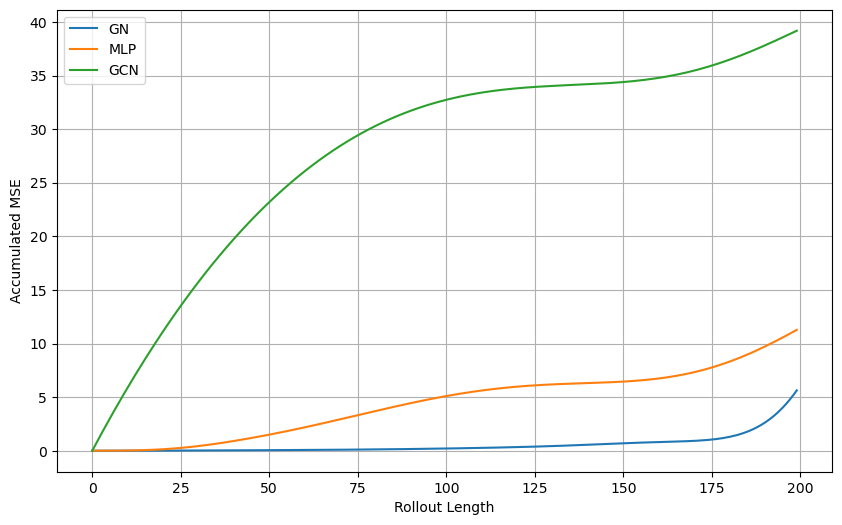

In [147]:
# Calculate MSE for each rollout length
mse_values5 = []
mse_values6 = []
mse_loss = nn.MSELoss(reduction='sum')
mse_rollout = 200
for i in range(mse_rollout):
    mse = mse_loss(denormalized_states[:i+1,:,:], pred_traj5[:i+1,:,:].detach())
    mse_values5.append(mse)
    
    mse = mse_loss(denormalized_states[:i+1,:,:], pred_traj6[:i+1,:,:].detach())
    mse_values6.append(mse)
    

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(mse_values2,label='GN')
plt.plot(mse_values5,label='MLP')
plt.plot(mse_values6,label='GCN')
plt.xlabel('Rollout Length')
plt.ylabel('Accumulated MSE')
plt.legend()
plt.grid(True)
plt.show()

## with control

In [152]:
mean[0].shape

torch.Size([10])

In [39]:
def data_gen(batch_size, sim_length,L=None,**args):
    args['tsteps'] = sim_length
    N = args['N']
    dt = args['dt']
    args['T'] = int(sim_length*dt)
    # note that time steps = T/dt, dt=0.1
    control_scales = [0.005, 0.1, 0.01,0.001]
    while True:
        data = torch.zeros((batch_size, sim_length, 2, N))
        controls = torch.zeros((batch_size, sim_length, N))

        for b in range(batch_size):
            init = functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,sim_length,d,dt,parameters,realizations,noise)# (2,N)
            args['node_ic'] = init
            control_scale = random.choice(control_scales)
            randcontrol = torch.rand((sim_length,N))*control_scale
            controls[b, :, :] = randcontrol
            data[b, :, :, :] = functions.plot_runge_kutta(functions.ODE_FHN_network,randcontrol, **args) # gives time seris of legth sim_length
        
        #normaliza
        data = (data - mean.unsqueeze(0).unsqueeze(0)) / std.unsqueeze(0).unsqueeze(0)
        #controls = (controls - mean[0].unsqueeze(0).unsqueeze(0)) / std[0].unsqueeze(0).unsqueeze(0)
        if L == None:
            # To return all the data at once
            yield(data, controls)
        else:
            # To return the data in chunks of length L
            num_chunks = sim_length // L
            for i in range(num_chunks):
                yield(data[:, i : i+L, :, :], controls[:, i : i+L, :])

In [13]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr, u, batch):

        return src[:, 0] * edge_attr

        
class NodeModel(torch.nn.Module):
    def __init__(self, hidden_sizes):
        super().__init__()
        
        num_node_features = 2
        in_channels = 3+1 
        hiddens = 2*in_channels

        layers = []
        input_size = in_channels
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, num_node_features))
        
        self.node_mlp = nn.Sequential(*layers)
        
    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0),
                      reduce='sum')
        out = torch.cat([x, out.unsqueeze(1)], dim=1)
        return self.node_mlp(out)

In [ ]:
# Define your grid
node_hidden_layer_combinations = [[16,32,16]]
learning_rates = [0.001]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_ahead = 10

max_epochs = 1000000

train_generator = data_gen(1, 400,L=10,**args)  # Assuming you've defined this already
valid_generator = data_gen(1, 400,L=10,**args)  # A separate generator for validation

# Start the grid search
results = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    # Create your models with the current hyperparameters
    edge_model = EdgeModel().to(device)
    node_model = NodeModel(node_sizes).to(device)
    model = MetaLayer(edge_model, node_model).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses = []
    valid_losses = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states,controls = next(train_generator)
        states,controls = states.to(device),controls.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
            controls = controls.squeeze(0)
        
        model.train()
        optimizer.zero_grad()
        loss = 0
        #print(states[0, :].shape,controls[0, :].shape)
        current_state = torch.cat((states[0, :], controls[0, :].unsqueeze(0)), dim=0) 
        for k in range(look_ahead-1):
            prediction = model(current_state.T, edge_index, edge_attr)[0].T
            loss = loss + loss_fn(prediction, states[k + 1, :])
            current_state = torch.cat((prediction, controls[k + 1, :].unsqueeze(0)), dim=0)
        
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model.eval()  # Switch the model to evaluation mode
            states,controls = next(train_generator)
            states,controls = states.to(device),controls.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
                controls = controls.squeeze(0)
            
            valid_loss = 0
            current_state = torch.cat((states[0, :], controls[0, :].unsqueeze(0)), dim=0) 
            for k in range(look_ahead-1):
                prediction = model(current_state.T, edge_index, edge_attr)[0].T
                valid_loss += loss_fn(prediction, states[k + 1, :])
                current_state = torch.cat((prediction, controls[k + 1, :].unsqueeze(0)), dim=0)
                
            valid_losses.append(valid_loss.item())

        epoch += 1  
        if (epoch + 1) % 20000 == 0: 
            print(f"Epoch {epoch + 1},Current Loss: {loss_value}")

Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.001
Epoch 20000,Current Loss: 0.012622920796275139
Epoch 40000,Current Loss: 0.031530532985925674
Epoch 60000,Current Loss: 0.03536669909954071
Epoch 80000,Current Loss: 0.015018854290246964
Epoch 100000,Current Loss: 0.022340677678585052
Epoch 120000,Current Loss: 0.040257908403873444
Epoch 140000,Current Loss: 0.011316349729895592
Epoch 160000,Current Loss: 0.021702907979488373
Epoch 180000,Current Loss: 0.007252095267176628
Epoch 200000,Current Loss: 0.0020644469186663628
Epoch 220000,Current Loss: 0.005406073294579983
Epoch 240000,Current Loss: 0.010640365071594715
Epoch 260000,Current Loss: 0.019450411200523376
Epoch 280000,Current Loss: 0.0032472843304276466
Epoch 300000,Current Loss: 0.0008133902447298169
Epoch 320000,Current Loss: 0.0009229955030605197
Epoch 340000,Current Loss: 0.0006788090104237199
Epoch 360000,Current Loss: 0.000713421031832695
Epoch 380000,Current Loss: 0.0006004686001688242
Epoch 400000,Curr

In [16]:
torch.save(model.state_dict(), 'gn_with_control')

In [40]:
model.eval()
t = 0
test_generator = data_gen(1, 1000,L=None,**args)
states,controls= next(test_generator)
states,controls = states.to(device),controls.to(device)
if states.shape[0] == 1:
    states = states.squeeze(0)
    controls = controls.squeeze(0)


In [41]:
controls

tensor([[0.0148, 0.0605, 0.0481,  ..., 0.0222, 0.0731, 0.0906],
        [0.0666, 0.0321, 0.0188,  ..., 0.0593, 0.0293, 0.0389],
        [0.0034, 0.0093, 0.0688,  ..., 0.0195, 0.0913, 0.0994],
        ...,
        [0.0233, 0.0491, 0.0727,  ..., 0.0144, 0.0552, 0.0689],
        [0.0568, 0.0777, 0.0064,  ..., 0.0005, 0.0659, 0.0535],
        [0.0983, 0.0918, 0.0462,  ..., 0.0435, 0.0898, 0.0298]])

In [22]:
pred_listc = [torch.cat((states[0, :,:], controls[0, :].unsqueeze(0)), dim=0)] 
for t in range(1000-1):
    current_state = pred_listc[t]
    prediction = model(current_state.T, edge_index, edge_attr)[0].T
    pred_listc.append(torch.cat((prediction, controls[t + 1, :].unsqueeze(0)), dim=0))

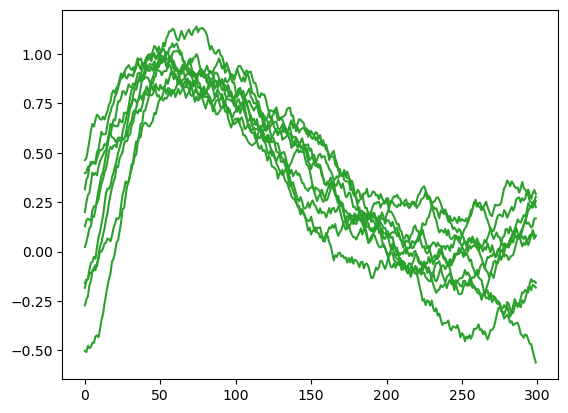

In [42]:
pred_trajc = torch.stack(pred_listc, dim=0)
#plt.plot(pred_trajc[:300,0,:].detach(),'C1--',label='prediction')
plt.plot(states[:300,0,:],'C2',label='prediction')
plt.show()